## Carga datos y limpieza

In [7]:
#Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

#Guardar modelos
from scipy.sparse import csr_matrix
from scipy import sparse


#LDA
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from pprint import pprint


In [12]:

file_path = "https://raw.githubusercontent.com/juankquintana/proyecto_recomendacion_peliculas/refs/heads/main/data/movies_metadata.csv"

metadata = pd.read_csv(file_path)

metadata.head(1)

,Unnamed: 0,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [13]:
import ast
def columnas_transformadas(metadata, columna, indicador, nuevo_nombre):
    # Crear una nueva columna temporal con los datos convertidos
    metadata['col_p'] = metadata[columna].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Extraer el valor deseado
    metadata[nuevo_nombre] = metadata['col_p'].apply(lambda x: [genre_p[indicador] for genre_p in x] if isinstance(x, list) else [])
    # Eliminar la columna temporal
    metadata = metadata.drop(columns=['col_p'])
    # Mostrar las primeras filas del nuevo nombre de columna
    print(metadata[nuevo_nombre].head(5))
    return metadata


metadata = columnas_transformadas(metadata, 'genres', 'name', 'genre_names')

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genre_names, dtype: object


In [16]:
file_path_keywords = "https://raw.githubusercontent.com/juankquintana/proyecto_recomendacion_peliculas/refs/heads/main/data/keywords.csv"

df_keywords = pd.read_csv(file_path_keywords,usecols=['id','keywords'])

df_keywords.head(5)


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [17]:
import ast

# Convertir la columna 'keywords' de string a una lista de diccionarios
df_keywords['keywords'] = df_keywords['keywords'].apply(ast.literal_eval)
df_keywords_exploded = df_keywords.explode('keywords')

df_keywords_exploded['keyword_id'] = df_keywords_exploded['keywords'].apply(lambda x: x['id'] if isinstance(x, dict) else None)
df_keywords_exploded['keyword_name'] = df_keywords_exploded['keywords'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Eliminar la columna original 'keywords'
df_keywords_exploded = df_keywords_exploded.drop(columns=['keywords'])

print(df_keywords_exploded.head(10))

     id  keyword_id       keyword_name
0   862         931           jealousy
0   862        4290                toy
0   862        5202                boy
0   862        6054         friendship
0   862        9713            friends
0   862        9823            rivalry
0   862      165503      boy next door
0   862      170722            new toy
0   862      187065  toy comes to life
1  8844       10090         board game


C:\Users\WD\AppData\Local\Temp\ipykernel_7904\3305871799.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='movie_count', y='keyword_name', data=top_25_keywords, palette='viridis')


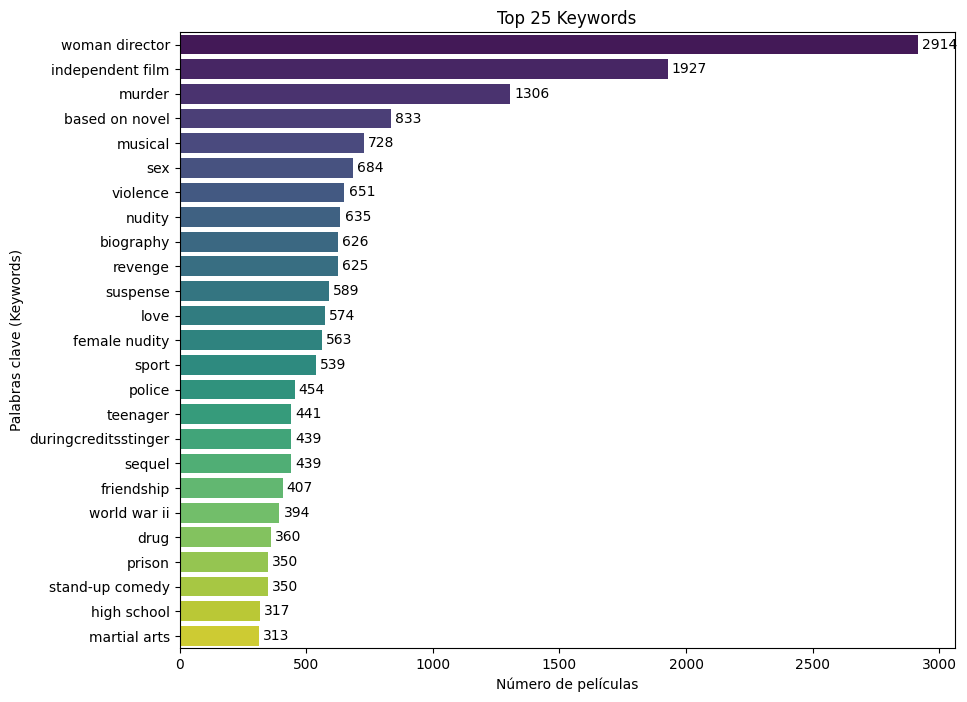

In [18]:
keyword_counts = df_keywords_exploded.groupby('keyword_name')['id'].count().reset_index(name='movie_count')

# Ordenar los datos por el número de películas para una mejor visualización
keyword_counts = keyword_counts.sort_values('movie_count', ascending=False)

top_25_keywords = keyword_counts.head(25)

# Graficar los datos
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='movie_count', y='keyword_name', data=top_25_keywords, palette='viridis')

# Agregar etiquetas de datos
for i in ax.containers:
    ax.bar_label(i, fmt='%d', label_type='edge', padding=3)

plt.xlabel('Número de películas')
plt.ylabel('Palabras clave (Keywords)')
plt.title('Top 25 Keywords')
plt.show()

In [19]:
df_grouped_keywords = df_keywords_exploded.groupby('id')['keyword_name'].apply(list).reset_index()

df_grouped_keywords.head()

,id,keyword_name
0,2,"[underdog, prison, factory worker, prisoner, h..."
1,3,"[salesclerk, helsinki, garbage, independent film]"
2,5,"[hotel, new year's eve, witch, bet, hotel room..."
3,6,"[chicago, drug dealer, boxing match, escape, o..."
4,11,"[android, galaxy, hermit, death star, lightsab..."


In [20]:
#!python -m spacy download en_core_web_sm

### Text cleaning keywords

In [21]:
import re
import spacy
import unidecode
from nltk.stem import SnowballStemmer

nlp = spacy.load('en_core_web_sm')

stemmer = SnowballStemmer('english')

def text_cleaning(txt, apply_lemma=True, apply_stemming=True):
    if not txt or pd.isna(txt):  # Verifica si el texto es None o NaN
        return ""
    
    # Eliminar caracteres especiales, tildes y convertir a minúsculas
    out = unidecode.unidecode(txt) 
    out = re.sub('[^A-Za-z0-9 ]+', ' ', out)  # Mantener solo letras y números
    out = re.sub("\d+", "", out)  # Eliminar números
    out = re.sub('\s+', ' ', out).strip()  # Remover espacios extra
    out = out.lower()  # Convertir a minúsculas

    # Tokenización en palabras
    lemmas = out.split()

    # Stemming
    if apply_stemming:
        stemmed = [stemmer.stem(lemma) for lemma in lemmas]
    else:
        stemmed = lemmas

    # Filtrar palabras cortas (menores de 3 caracteres) y eliminar posibles vacíos
    cleaned = [word for word in stemmed if len(word) > 2]

    return " ".join(cleaned) if cleaned else ""



<>:17: DeprecationWarning: invalid escape sequence '\d'
<>:18: DeprecationWarning: invalid escape sequence '\s'
<>:17: DeprecationWarning: invalid escape sequence '\d'
<>:18: DeprecationWarning: invalid escape sequence '\s'
C:\Users\WD\AppData\Local\Temp\ipykernel_7904\2306704377.py:17: DeprecationWarning: invalid escape sequence '\d'
  out = re.sub("\d+", "", out)  # Eliminar números
C:\Users\WD\AppData\Local\Temp\ipykernel_7904\2306704377.py:18: DeprecationWarning: invalid escape sequence '\s'
  out = re.sub('\s+', ' ', out).strip()  # Remover espacios extra


In [22]:
# Aplicar la limpieza a cada palabra clave en las listas de 'keyword_name'
df_grouped_keywords['cleaned_keywords'] = df_grouped_keywords['keyword_name'].apply(
    lambda keywords: [text_cleaning(kw) for kw in keywords if kw]  # Verificar si cada keyword no es None
)

# Mostrar las primeras filas con las palabras clave limpias
print(df_grouped_keywords[['id', 'cleaned_keywords']].head())

   id                                   cleaned_keywords
0   2  [underdog, prison, factori worker, prison, hel...
1   3      [salesclerk, helsinki, garbag, independ film]
2   5  [hotel, new year eve, witch, bet, hotel room, ...
3   6  [chicago, drug dealer, box match, escap, one n...
4  11  [android, galaxi, hermit, death star, lightsab...


In [23]:
df_grouped_keywords[df_grouped_keywords['id']==862][['keyword_name','cleaned_keywords']]


,keyword_name,cleaned_keywords
680,"[jealousy, toy, boy, friendship, friends, riva...","[jealousi, toy, boy, friendship, friend, rival..."


### Cruzar titulo original y generos a la lista

In [24]:
# Convert 'movieId' column in df_ratings to object type
df_grouped_keywords['id'] = df_grouped_keywords['id'].astype(str)

# Now perform the merge operation
df_keywords_title = pd.merge(df_grouped_keywords, metadata[['id', 'original_title','genre_names']],
                     left_on='id', right_on='id', how='left')

# Seleccionar solo las columnas que necesitas
df_keywords_title = df_keywords_title[['id','original_title', 'keyword_name','cleaned_keywords','genre_names']]

# Mostrar el DataFrame final
df_keywords_title.head()

,id,original_title,keyword_name,cleaned_keywords,genre_names
0,2,Ariel,"[underdog, prison, factory worker, prisoner, h...","[underdog, prison, factori worker, prison, hel...","[Drama, Crime]"
1,3,Varjoja paratiisissa,"[salesclerk, helsinki, garbage, independent film]","[salesclerk, helsinki, garbag, independ film]","[Drama, Comedy]"
2,5,Four Rooms,"[hotel, new year's eve, witch, bet, hotel room...","[hotel, new year eve, witch, bet, hotel room, ...","[Crime, Comedy]"
3,6,Judgment Night,"[chicago, drug dealer, boxing match, escape, o...","[chicago, drug dealer, box match, escap, one n...","[Action, Thriller, Crime]"
4,11,Star Wars,"[android, galaxy, hermit, death star, lightsab...","[android, galaxi, hermit, death star, lightsab...","[Adventure, Action, Science Fiction]"


In [25]:
df_keywords_title['cleaned_keywords'] = df_keywords_title.apply(lambda row: row['genre_names'] + row['cleaned_keywords'], axis=1)
#df_keywords_title = df_keywords_title.drop(columns=['genre_names'])
df_keywords_title.head()

,id,original_title,keyword_name,cleaned_keywords,genre_names
0,2,Ariel,"[underdog, prison, factory worker, prisoner, h...","[Drama, Crime, underdog, prison, factori worke...","[Drama, Crime]"
1,3,Varjoja paratiisissa,"[salesclerk, helsinki, garbage, independent film]","[Drama, Comedy, salesclerk, helsinki, garbag, ...","[Drama, Comedy]"
2,5,Four Rooms,"[hotel, new year's eve, witch, bet, hotel room...","[Crime, Comedy, hotel, new year eve, witch, be...","[Crime, Comedy]"
3,6,Judgment Night,"[chicago, drug dealer, boxing match, escape, o...","[Action, Thriller, Crime, chicago, drug dealer...","[Action, Thriller, Crime]"
4,11,Star Wars,"[android, galaxy, hermit, death star, lightsab...","[Adventure, Action, Science Fiction, android, ...","[Adventure, Action, Science Fiction]"


In [26]:
clean_keywords=df_keywords_title["cleaned_keywords"]

clean_sentences= [" ".join(i) for i in clean_keywords]

type(clean_sentences)

list

#### Guardar datos clean

In [28]:
#df_keywords_title.to_pickle('df_keywords_title.pkl')


## Count Vectorizer

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

count=CountVectorizer()
count_matrix=count.fit_transform(clean_sentences)
count_matrix

<30746x10690 sparse matrix of type '<class 'numpy.int64'>'
	with 278774 stored elements in Compressed Sparse Row format>

In [30]:
print(count_matrix.shape)
print(len(df_keywords_title))


(30746, 10690)
30746


In [31]:
#Dependiente de la RAM

#Calculamos la matriz de similitud de coseno
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)
cosine_sim_count

array([[1.        , 0.40406102, 0.11952286, ..., 0.        , 0.        ,
        0.        ],
       [0.40406102, 1.        , 0.16903085, ..., 0.        , 0.        ,
        0.16903085],
       [0.11952286, 0.16903085, 1.        , ..., 0.        , 0.        ,
        0.1       ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.31622777,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.31622777, 1.        ,
        0.        ],
       [0.        , 0.16903085, 0.1       , ..., 0.        , 0.        ,
        1.        ]])

In [32]:
def recomendador_coseno(movie_id, cosine_sim, num_recomendaciones=5, df=df_keywords_title):
    # Crear una Serie que contiene como índice el 'id' y el valor correspondiente al índice de la película
    indices = pd.Series(df.index, index=df['id'])

    # Verificar si el movie_id está en los índices
    if movie_id not in indices.index:
        print(f'ID de película {movie_id} no encontrado.')
        return

    # Obtener el índice de la película a partir del movie_id
    idx = indices[movie_id]

    # Obtener el título de la película original
    original_title = df.loc[idx, 'original_title']
    print(f'Título de la película original: {original_title}')
    print(f'Índice de la película: {movie_id}')

    # Obtener la similitud de coseno para esa película en particular con todas las películas
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordenar la lista de tuplas por la similitud de coseno en orden descendente
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtener las películas más similares ignorando el primero (que es la misma película)
    sim_scores = sim_scores[1:num_recomendaciones+1]

    # Obtener los índices y las similitudes
    movie_indices = [i[0] for i in sim_scores]
    sim_scores_values = [i[1] for i in sim_scores]

    # Verificar que los índices obtenidos están dentro del rango del DataFrame
    valid_indices = [idx for idx in movie_indices if idx in df.index]

    # Crear un DataFrame para mostrar los resultados
    result_df = pd.DataFrame({
        'Índice': valid_indices,
        'Título': df['original_title'].iloc[valid_indices].values,
        'Similitud Coseno': [sim_scores_values[movie_indices.index(idx)] for idx in valid_indices]
    })

    # Imprimir las películas recomendadas con sus índices y similitudes
    print('\nPelículas recomendadas:')
    

    # Retornar el DataFrame con los resultados
    return result_df

In [33]:
from scipy.stats import pearsonr
def recomendador_correlacion(movie_id, count_matrix,  num_recomendaciones=5,df=df_keywords_title):
    # Crear una Serie que contiene como índice el 'id' y el valor correspondiente al índice de la película
    indices = pd.Series(df.index, index=df['id'])

    # Verificar si el movie_id está en los índices
    if movie_id not in indices.index:
        print(f'ID de película {movie_id} no encontrado.')
        return

    # Obtener el índice de la película a partir del movie_id
    idx = indices[movie_id]

    # Convertir la matriz count_matrix a una matriz densa (numpy array)
    count_matrix_dense = count_matrix.toarray()

    # Obtener el vector de conteo de la película objetivo
    target_vector = count_matrix_dense[idx]

    # Calcular la correlación de Pearson entre la película objetivo y todas las demás
    correlations = []
    for i in range(count_matrix_dense.shape[0]):
        if i != idx:
            vector = count_matrix_dense[i]
            # Calcular la correlación de Pearson entre el vector objetivo y el vector de la película i
            corr, _ = pearsonr(target_vector, vector)
            correlations.append((i, corr))

    # Ordenar las películas según la correlación en orden descendente
    correlations = sorted(correlations, key=lambda x: x[1], reverse=True)

    # Obtener los índices de las películas más correlacionadas
    correlations = correlations[:num_recomendaciones]

    # Obtener los índices y los valores de correlación
    movie_indices = [i[0] for i in correlations]
    correlation_values = [i[1] for i in correlations]

    # Crear un DataFrame para mostrar los resultados
    result_df = pd.DataFrame({
        'Índice': movie_indices,
        'Título': df['original_title'].iloc[movie_indices].values,
        'Correlación Pearson': correlation_values
    })

    # Imprimir las películas recomendadas con sus índices y correlaciones
    print('\nPelículas recomendadas:')

    # Retornar el DataFrame con los resultados
    return result_df

# Ejemplo de uso:
# df es el DataFrame que contiene 'id', 'original_title' y otras columnas.
# recomendador_correlacion(movie_id=1, count_matrix=count_matrix, df=df)

In [25]:
recomendador_correlacion('862', count_matrix, num_recomendaciones=10)

c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))



Películas recomendadas:
 Índice                                Título  Correlación Pearson
  11130                      Babes in Toyland             0.461644
   5275                       Bride of Chucky             0.401899
    683                           Toy Story 2             0.400793
   1171           The Transformers: The Movie             0.387819
   3566                          Home Alone 3             0.366372
   3212                         Monster House             0.361141
  13887                            Wide Awake             0.357337
   1447        Mr. Magorium's Wonder Emporium             0.349277
   5735 Scooby-Doo! and the Loch Ness Monster             0.346095
   7600     Scooby-Doo! and the Samurai Sword             0.346095


,Índice,Título,Correlación Pearson
0,11130,Babes in Toyland,0.461644
1,5275,Bride of Chucky,0.401899
2,683,Toy Story 2,0.400793
3,1171,The Transformers: The Movie,0.387819
4,3566,Home Alone 3,0.366372
5,3212,Monster House,0.361141
6,13887,Wide Awake,0.357337
7,1447,Mr. Magorium's Wonder Emporium,0.349277
8,5735,Scooby-Doo! and the Loch Ness Monster,0.346095
9,7600,Scooby-Doo! and the Samurai Sword,0.346095


In [64]:
#Nuevo con genero
recomendador_coseno('862', cosine_sim_count, num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,38815,Toy Story That Time Forgot,0.565685
1,3946,Toy Story 3,0.548795
2,5005,Small Soldiers,0.538816
3,10264,Barbie and the Three Musketeers,0.500000
4,36950,Toy Story of Terror!,0.489898
5,4722,Child's Play 2,0.482418
6,11130,Babes in Toyland,0.461880
7,44051,Monster High: Great Scarrier Reef,0.447214
8,25018,Ted,0.427618
9,14868,The Tangerine Bear: Home in Time for Christmas!,0.424264


In [57]:
#Viejo sin genero
recomendador_coseno('862', cosine_sim_count, num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,5005,Small Soldiers,0.596962
1,4722,Child's Play 2,0.568535
2,38815,Toy Story That Time Forgot,0.522233
3,3946,Toy Story 3,0.497796
4,10264,Barbie and the Three Musketeers,0.452267
5,10521,Dolls,0.452267
6,11130,Babes in Toyland,0.452267
7,25018,Ted,0.430820
8,27239,Beshkempir,0.426401
9,4250,Child's Play,0.402015


### Guardar Count Vectorizer

In [36]:
# from scipy.sparse import csr_matrix
# from scipy import sparse
# cosine_sim_sparse = csr_matrix(cosine_sim_count)

# #Guardar la matriz dispersa en un archivo 
# sparse.save_npz('cosine_sim_sparse_matrixCOUNT.npz', cosine_sim_sparse)

### Cargar Count Vectorizer

In [67]:
cosine_sim_sparseCOUNT = sparse.load_npz('ModelosNLP/cosine_sim_sparse_matrixCOUNT.npz')

# Convertirla de nuevo a densa (si es necesario, aunque puedes seguir usándola como dispersa)
cosine_sim_sparseCOUNT = cosine_sim_sparseCOUNT.toarray()


MemoryError: Unable to allocate 15.4 GiB for an array with shape (45462, 45462) and data type float64

In [19]:
recomendador_coseno('862', cosine_sim_sparseCOUNT,num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,3946,Toy Story 3,0.566667
1,38815,Toy Story That Time Forgot,0.565685
2,5005,Small Soldiers,0.538816
3,10264,Barbie and the Three Musketeers,0.500000
4,36950,Toy Story of Terror!,0.489898
5,4722,Child's Play 2,0.482418
6,11130,Babes in Toyland,0.461880
7,44051,Monster High: Great Scarrier Reef,0.447214
8,25018,Ted,0.427618
9,14868,The Tangerine Bear: Home in Time for Christmas!,0.424264


## TF-IDF Vectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Definimos el objeto TF-IDF Vectorizer Object
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(clean_sentences)

#Dimensiones de la matriz
print('Shape de la matriz: ',tfidf_matrix.shape)

Shape de la matriz:  (45462, 10689)


In [20]:
#Calculamos la matriz de similitud de coseno para el TF-IDF
cosine_sim_TFIDF = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_TFIDF

array([[1.        , 0.32212725, 0.03916419, ..., 0.04361084, 0.        ,
        0.03425333],
       [0.32212725, 1.        , 0.0384641 , ..., 0.05658173, 0.0222974 ,
        0.04444107],
       [0.03916419, 0.0384641 , 1.        , ..., 0.        , 0.01314303,
        0.        ],
       ...,
       [0.04361084, 0.05658173, 0.        , ..., 1.        , 0.18521712,
        0.22073739],
       [0.        , 0.0222974 , 0.01314303, ..., 0.18521712, 1.        ,
        0.27112961],
       [0.03425333, 0.04444107, 0.        , ..., 0.22073739, 0.27112961,
        1.        ]])

In [58]:
recomendador_coseno('862', cosine_sim_TFIDF,num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,5005,Small Soldiers,0.600869
1,38815,Toy Story That Time Forgot,0.598064
2,10264,Barbie and the Three Musketeers,0.596729
3,4722,Child's Play 2,0.555918
4,11130,Babes in Toyland,0.527988
5,3946,Toy Story 3,0.483533
6,10521,Dolls,0.483500
7,44051,Monster High: Great Scarrier Reef,0.463308
8,5044,Toys,0.426696
9,36950,Toy Story of Terror!,0.424615


No me gusta tanto porque quita peso a los generos

### Guardar TFIDF Vectorizer

In [1]:
# from scipy.sparse import csr_matrix
# from scipy import sparse
# cosine_sim_sparseTFIDF = csr_matrix(cosine_sim_TFIDF)

# # Guardar la matriz dispersa en un archivo
# sparse.save_npz('ModelosNLP/cosine_sim_sparse_matrixTFIDF.npz', cosine_sim_sparseTFIDF)

### Cargar TFIDF Vect

In [1]:
cosine_sim_sparseTFIDF = sparse.load_npz('ModelosNLP/cosine_sim_sparse_matrixTFIDF.npz')

# Convertirla de nuevo a densa (si es necesario, aunque puedes seguir usándola como dispersa)
cosine_sim_sparseTFIDF = cosine_sim_sparseTFIDF.toarray()


NameError: name 'sparse' is not defined

In [27]:
recomendador_coseno('862', cosine_sim_sparseTFIDF,num_recomendaciones=10)

Título de la película original: Toy Story
Índice de la película: 862

Películas recomendadas:


,Índice,Título,Similitud Coseno
0,38815,Toy Story That Time Forgot,0.610571
1,10264,Barbie and the Three Musketeers,0.584379
2,5005,Small Soldiers,0.581319
3,4722,Child's Play 2,0.539494
4,11130,Babes in Toyland,0.521613
5,3946,Toy Story 3,0.505161
6,44051,Monster High: Great Scarrier Reef,0.481568
7,10521,Dolls,0.462427
8,36950,Toy Story of Terror!,0.453366
9,5044,Toys,0.416538


## Correlacion Count Vect

In [59]:
from scipy.spatial.distance import correlation
import pandas as pd

def recomendador_correlacion(movie_id, cosine_sim, num_recomendaciones=5,df=df_keywords_title):
    # Crear una Serie que contiene como índice el 'id' y el valor correspondiente al índice de la película
    indices = pd.Series(df.index, index=df['id'])

    # Verificar si el movie_id está en los índices
    if movie_id not in indices.index:
        print(f'ID de película {movie_id} no encontrado.')
        return

    # Obtener el índice de la película a partir del movie_id
    idx = indices[movie_id]

    # Obtener el vector TF-IDF de la película objetivo
    target_vector = cosine_sim[idx]

    # Calcular la correlación entre el vector de la película objetivo y todos los vectores
    correlations = []
    for i in range(cosine_sim.shape[0]):
        if i != idx:
            vector = cosine_sim[i]
            # Correlación = 1 - distancia para convertir distancia en correlación
            corr = 1 - correlation(target_vector, vector)
            correlations.append((i, corr))

    # Ordenar la lista de tuplas por la correlación en orden descendente
    correlations = sorted(correlations, key=lambda x: x[1], reverse=True)

    # Obtener las películas más similares ignorando el primero (que es la misma película)
    correlations = correlations[1:num_recomendaciones+1]

    # Obtener los índices y las correlaciones
    movie_indices = [i[0] for i in correlations]
    correlation_values = [i[1] for i in correlations]

    # Verificar que los índices obtenidos están dentro del rango del DataFrame
    valid_indices = [idx for idx in movie_indices if idx in df.index]

    # Crear un DataFrame para mostrar los resultados
    result_df = pd.DataFrame({
        'Índice': valid_indices,
        'Título': df['original_title'].iloc[valid_indices].values,
        'Correlación': [correlation_values[movie_indices.index(idx)] for idx in valid_indices]
    })

    # Imprimir las películas recomendadas con sus índices y correlaciones
    print('\nPelículas recomendadas:')
    #print(result_df.to_string(index=False))

    # Retornar el DataFrame con los resultados
    return result_df

### Probar modelo

In [60]:
recomendador_correlacion('862', cosine_sim_sparseCOUNT,num_recomendaciones=10)

NameError: name 'cosine_sim_sparseCOUNT' is not defined

In [63]:
recomendador_correlacion('862', cosine_sim_count,num_recomendaciones=10)

c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\scipy\spatial\distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)



Películas recomendadas:


,Índice,Título,Correlación
0,828,The Talented Mr. Ripley,0.440668
1,5161,Peter's Friends,0.421081
2,2459,Dinner for One,0.400048
3,5168,Naked in New York,0.395206
4,5258,Hatchet,0.391134
5,5629,The Mouse That Roared,0.383418
6,5277,The Hudsucker Proxy,0.367925
7,2432,Evening,0.361348
8,5623,"New York, New York",0.357437
9,890,Y tu mamá también,0.355928


## LDA (sirve mejor para textos mas largos)

In [64]:
from gensim.corpora import Dictionary

dictionary = Dictionary(clean_keywords)
dictionary

In [65]:
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in clean_keywords]

print('Numero de palabras únicas: %d' % len(dictionary))

Numero de palabras únicas: 1510


In [66]:
from gensim.models import LdaModel

Estimacion = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=4,
    chunksize=1000,
    passes=20,
    iterations=400,
    alpha='auto',
    eta='auto',
    random_state=123,
    eval_every=None
)

In [67]:
from pprint import pprint

pprint(Estimacion.print_topics())

[(0,
  '0.049*"murder" + 0.023*"violenc" + 0.022*"reveng" + 0.020*"short" + '
  '0.018*"sport" + 0.016*"base true stori" + 0.015*"kidnap" + 0.015*"polic" + '
  '0.013*"suspens" + 0.012*"prison"'),
 (1,
  '0.068*"stand comedi" + 0.045*"" + 0.018*"anim" + 0.016*"zombi" + '
  '0.016*"polit" + 0.015*"war" + 0.013*"ghost" + 0.013*"dog" + 0.012*"monster" '
  '+ 0.012*"found footag"'),
 (2,
  '0.051*"music" + 0.035*"teenag" + 0.031*"sequel" + 0.030*"sex" + '
  '0.027*"femal nuditi" + 0.025*"high school" + 0.024*"nuditi" + '
  '0.019*"supernatur" + 0.017*"superhero" + 0.016*"danc"'),
 (3,
  '0.154*"woman director" + 0.036*"biographi" + 0.029*"base novel" + '
  '0.019*"love" + 0.017*"independ film" + 0.016*"christma" + 0.014*"famili" + '
  '0.013*"world war" + 0.013*"friendship" + 0.011*"lgbt"')]


In [68]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(Estimacion, corpus, dictionary)
LDA_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.378784  0.094613       1        1  33.149570
0      0.250555  0.291733       2        1  29.078808
1      0.105868 -0.342707       3        1  21.831208
2      0.022361 -0.043638       4        1  15.940415, topic_info=                Term         Freq        Total Category  logprob  loglift
11    woman director  5194.000000  5194.000000  Default  30.0000  30.0000
1493    stand comedi  1512.000000  1512.000000  Default  29.0000  29.0000
68            murder  1453.000000  1453.000000  Default  28.0000  28.0000
441            music   826.000000   826.000000  Default  27.0000  27.0000
218                    993.000000   993.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
716           crimin   117.511663   118.617802   Topic4  -4.9301   1.8269
791           summer   112.696618   113.782242   Topic4  -4.9719   1.8267
581   nativ american   108.780410   109.860638   Topic4  -5.0073   1.8264
1357           grief   117.472739   118.657063   Topic4  -4.9304   1.8263
450         musician   101.311990   102.385435   Topic4  -5.0784   1.8258

[156 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
218       3  0.998742                   
20        3  0.994093  aftercreditssting
109       1  0.995892            alcohol
84        3  0.996688              alien
264       3  0.998204               anim
...     ...       ...                ...
266       3  0.997735                war
125       1  0.992785                wed
11        1  0.999770     woman director
478       1  0.996616          world war
541       3  0.995887              zombi

[127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [69]:
from gensim.models import CoherenceModel

coherencemodel = CoherenceModel(model=Estimacion, texts=clean_keywords, dictionary=dictionary)
coherencemodel.get_coherence() 

0.40906015431155235

In [70]:
from gensim.models.ldamulticore import LdaMulticore

def calcular_coherencia(dictionary, corpus, texts, start=1, limit=10, step=1):
 
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=123,
                        passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [71]:
modelos, valores_c = calcular_coherencia(dictionary=dictionary, corpus=corpus, texts=clean_keywords, start=1, limit=10, step=1)


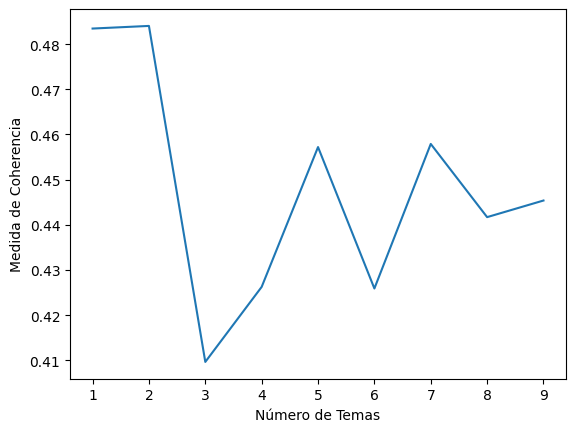

In [72]:

# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, valores_c)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Coherencia")
plt.show()

In [73]:
lda_model_opt = LdaMulticore(corpus = corpus,
    id2word = dictionary,
    num_topics = 2,
    random_state=123)
pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(lda_model_opt, corpus, dictionary)
LDA_visualization

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.019565  0.0       1        1  52.678585
1     -0.019565  0.0       2        1  47.321415, topic_info=              Term         Freq        Total Category  logprob  loglift
68          murder  1300.000000  1300.000000  Default  30.0000  30.0000
24      base novel   771.000000   771.000000  Default  29.0000  29.0000
48          nuditi   680.000000   680.000000  Default  28.0000  28.0000
606  serial killer   296.000000   296.000000  Default  27.0000  27.0000
266            war   198.000000   198.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
82          suicid   166.047368   317.658458   Topic2  -5.6725   0.0995
323         sequel   171.198282   450.181095   Topic2  -5.6419  -0.2186
24      base novel   176.629624   771.178607   Topic2  -5.6107  -0.7257
42    femal nuditi   169.616613   584.861660   Topic2  -5.6512  -0.4896
48          nuditi   166.509951   680.865632   Topic2  -5.6697  -0.6601

[176 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
218       1  0.490490                   
218       2  0.508841                   
20        1  0.249194  aftercreditssting
20        2  0.747581  aftercreditssting
241       1  0.298600            airplan
...     ...       ...                ...
105       2  0.801274             worker
478       1  0.533923          world war
478       2  0.467451          world war
541       1  0.310574              zombi
541       2  0.688300              zombi

[252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [74]:
def perplejidad_ntemas(dictionary, corpus, texts, start=1, limit=10, step=1):
 
    perplejidad_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=123,
                        passes=20)
        model_list.append(model)
        perplejidad_values.append(np.exp2(-model.log_perplexity(corpus)))

    return model_list, perplejidad_values

In [75]:
modelos, valores_p = perplejidad_ntemas(dictionary=dictionary, corpus=corpus, texts=clean_keywords, start=1, limit=10, step=1)


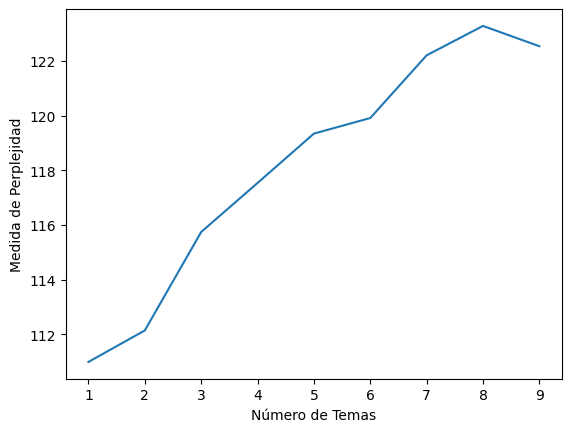

In [76]:
import matplotlib.pyplot as plt
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, valores_p)
plt.xlabel("Número de Temas")
plt.ylabel("Medida de Perplejidad")

plt.show()

In [77]:
Estimacion = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    chunksize=1000,
    passes=20,
    iterations=400,
    alpha='auto',
    eta='auto',
    random_state=123,
    eval_every=None
)


pprint(Estimacion.print_topics())

[(0,
  '0.032*"murder" + 0.028*"biographi" + 0.023*"base novel" + 0.015*"violenc" + '
  '0.014*"reveng" + 0.014*"independ film" + 0.013*"short" + 0.012*"sport" + '
  '0.011*"sex" + 0.010*"base true stori"'),
 (1,
  '0.038*"" + 0.018*"sequel" + 0.016*"world war" + 0.015*"anim" + '
  '0.014*"zombi" + 0.014*"lgbt" + 0.013*"polit" + 0.012*"war" + 0.012*"come '
  'age" + 0.012*"comedi"'),
 (2,
  '0.174*"woman director" + 0.051*"stand comedi" + 0.026*"music" + '
  '0.022*"love" + 0.018*"teenag" + 0.018*"christma" + 0.015*"famili" + '
  '0.014*"friendship" + 0.012*"high school" + 0.010*"documentari"')]


### Guardar LDA

In [20]:
# Estimacion.save('ModelosNLP/lda_model_estimacion.pkl')

### Cargar LDA

In [23]:
# Estimacion_Pickle = LdaModel.load('ModelosNLP/lda_model_estimacion.pkl')

In [21]:
df_keywords_title[df_keywords_title['id']=='862'].index[0]

682

In [78]:
l=[Estimacion.get_document_topics(item) for item in corpus]
#'La venganza del metegol'
l[682]

[(0, 0.29471806), (1, 0.3061052), (2, 0.39917675)]

In [79]:
def recomendador_LDA(id_movie, l, num_recomendaciones=5, df=df_keywords_title):
    # Crear una Serie que contiene como índice el 'id' y el valor correspondiente al índice de la película
    indices = pd.Series(df.index, index=df['id'])
    
    # Verificar si el id_movie está en los índices
    if id_movie not in indices.index:
        print(f"ID de película {id_movie} no encontrado.")
        return

    # Obtener el índice de la película a partir del id_movie
    idx = indices[id_movie]
    
    original_title = df.loc[idx, 'original_title']

    # Obtener las probabilidades de temas para la película
    topics_for_movie = l[idx]
    
    # Encontrar el tema con la mayor probabilidad (el tema dominante)
    tema_dominante, prob_dominante = max(topics_for_movie, key=lambda x: x[1])

    # Verificar los temas y probabilidades de la película original
    print(f"Tema dominante de la película '{original_title}' (ID: {id_movie}): {tema_dominante}")
    print(f"Probabilidades de temas para la película original: {topics_for_movie}")

    # Obtener todas las películas que comparten el mismo tema dominante
    peliculas_similares = [i for i, temas in enumerate(l) if any(tema == tema_dominante for tema, prob in temas)]
    
    # Excluir la película original (id_movie)
    peliculas_similares = [i for i in peliculas_similares if i != idx]

    # Obtener la probabilidad del tema dominante para las películas recomendadas
    probabilidad_tema_dominante = []
    for i in peliculas_similares:
        for tema, prob in l[i]:
            if tema == tema_dominante:
                probabilidad_tema_dominante.append((i, prob))
                break

    # Ordenar las películas recomendadas por la probabilidad del tema dominante en orden descendente
    probabilidad_tema_dominante = sorted(probabilidad_tema_dominante, key=lambda x: x[1], reverse=True)
    
    # Limitar el número de recomendaciones al parámetro num_recomendaciones
    probabilidad_tema_dominante = probabilidad_tema_dominante[:num_recomendaciones]

    # Obtener los índices y probabilidades
    peliculas_similares_indices = [i[0] for i in probabilidad_tema_dominante]
    peliculas_similares_probs = [i[1] for i in probabilidad_tema_dominante]

    # Crear un DataFrame para mostrar los resultados
    result_df = pd.DataFrame({
        'Índice': peliculas_similares_indices,
        'Título': df['original_title'].iloc[peliculas_similares_indices].values,
        'Probabilidad Tema Dominante': peliculas_similares_probs
    })

    # Imprimir el tema dominante de la película original y el título
    print(f"Tema dominante de la película original (ID: {id_movie}): {tema_dominante}")
    print(f"Título de la película original: {original_title}")
    
    # Imprimir las películas recomendadas con la probabilidad del tema dominante
    print("\nPelículas recomendadas:")
    #for i, row in result_df.iterrows():
     #   print(f"Índice: {row['Índice']}, Título: {row['Título']}, Probabilidad Tema Dominante: {row['Probabilidad Tema Dominante']:.4f}")
    
    # Retornar el DataFrame con los resultados
    return result_df

In [80]:
recomendador_LDA('862', l,num_recomendaciones=10)

Tema dominante de la película 'Toy Story' (ID: 862): 2
Probabilidades de temas para la película original: [(0, 0.29471806), (1, 0.3061052), (2, 0.39917675)]
Tema dominante de la película original (ID: 862): 2
Título de la película original: Toy Story

Películas recomendadas:


,Índice,Título,Probabilidad Tema Dominante
0,34093,एबीसीडी,0.755740
1,1902,Blindsight,0.755366
2,35474,In Old Santa Fe,0.718472
3,1815,Efter brylluppet,0.718376
4,24347,Cougar Hunting,0.718363
5,3275,Crazy,0.717189
6,521,Central do Brasil,0.695193
7,41810,Krisha,0.668519
8,43787,Fitoor,0.668089
9,42124,Top Spin,0.668084
